## Chapter 6 Lab: Linear Models and Regularization Methods

In [1]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
from statsmodels.api import OLS
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from functools import partial

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from ISLP.models import \
                (Stepwise,
                sklearn_selected,
                sklearn_selection_path)

In [3]:
!pip install l0bnb
from l0bnb import fit_path

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for l0bnb: filename=l0bnb-1.0.0-py3-none-any.whl size=22298 sha256=f9025c6e6a3348b7e7281d0cfdc38f5efad38ac046d7b0cf410e088a8fbfd569
  Stored in directory: /Users/hildeyounce/Library/Caches/pip/wheels/56/b6/7a/2a78772d92aa67f0d038759a09c7e950b5a708d5ecd5c0e38d
Successfully built l0bnb


### Subset Selection Methods

#### Forward Selection

We will use the Hitters baseball dataset, and are interested in predicting a player's Salary.

In [5]:
hitters = load_data('Hitters')
np.isnan(hitters['Salary']).sum() # How many missing responses?

59

In [6]:
# Remove rows with missing variables
hitters = hitters.dropna()
hitters.shape

(263, 20)

**Model selection based on Cp:**

In [7]:
# Function to compute Cp
def nCp(sigma2, estimator, X, Y):
    "Negative Cp statistic"
    n,p = X.shape
    Yhat = estimator.predict(X)
    RSS = np.sum((Y - Yhat)**2)
    return -(RSS + 2 * p * sigma2) / n

In [8]:
# Fit model with all variables and estimate sigma2
design = MS(hitters.columns.drop('Salary')).fit(hitters)
Y = np.array(hitters['Salary'])
X = design.transform(hitters)
sigma2 = OLS(Y,X).fit().scale

In [13]:
# Freeze first argument with our estimate
neg_Cp = partial(nCp, sigma2)

The method Stepwise.first_peak() from the ISLP.models package runs forward stepwise selection until any further additions to the model do not result in an improvement in the evaluation score. 

In [14]:
# Specify search strategy
strategy = Stepwise.first_peak(design, direction='forward', max_terms=len(design.terms))

In [15]:
# Fit linear regression model using forward selection
hitters_MSE = sklearn_selected(OLS, strategy)
hitters_MSE.fit(hitters, Y)
hitters_MSE.selected_state_

('Assists',
 'AtBat',
 'CAtBat',
 'CHits',
 'CHmRun',
 'CRBI',
 'CRuns',
 'CWalks',
 'Division',
 'Errors',
 'Hits',
 'HmRun',
 'League',
 'NewLeague',
 'PutOuts',
 'RBI',
 'Runs',
 'Walks',
 'Years')

In [16]:
# Fit using Cp
hitters_Cp = sklearn_selected(OLS, strategy, scoring=neg_Cp)
hitters_Cp.fit(hitters, Y)
hitters_Cp.selected_state_

('Assists',
 'AtBat',
 'CAtBat',
 'CRBI',
 'CRuns',
 'CWalks',
 'Division',
 'Hits',
 'PutOuts',
 'Walks')

**Model selection with validation set approach and cross-validation:**

The function cross_val_predict() from ISLP.models computes the cross-validated predictions for each of the models along a specified path.

In [18]:
# Define strategy: select based on biggest reduction in RSS
strategy = Stepwise.fixed_steps(design, len(design.terms), direction='forward')
full_path = sklearn_selection_path(OLS, strategy)

In [19]:
# Compute fitted values
full_path.fit(hitters,Y)
Yhat_in = full_path.predict(hitters)
Yhat_in.shape

(263, 20)

(50000.0, 250000.0)

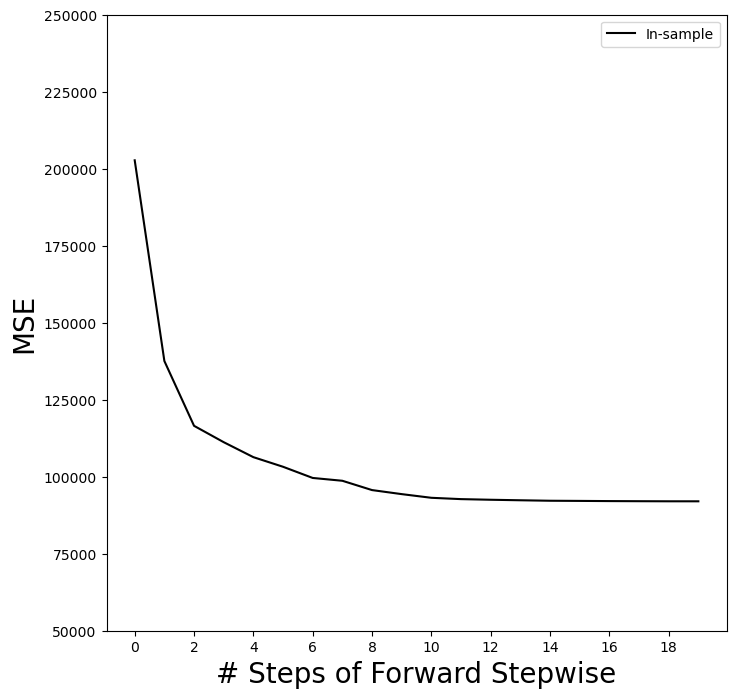

In [23]:
# Plot MSE vs. Steps taken
mse_fig , ax = subplots(figsize=(8,8))
insample_mse = ((Yhat_in - Y[:, None])**2).mean(0)
n_steps = insample_mse.shape[0]

ax.plot(np.arange(n_steps), insample_mse, 'k', label='In-sample')
ax.set_ylabel('MSE', fontsize=20)
ax.set_xlabel('# Steps of Forward Stepwise', fontsize=20)
ax.set_xticks(np.arange(n_steps)[::2])
ax.legend()
ax.set_ylim([50000, 250000])

In [24]:
# Use cross-validation to estimate test error
k = 5
kfold = skm.KFold(k, random_state=0, shuffle=True)
Yhat_cv = skm.cross_val_predict(full_path, hitters, Y, cv=kfold)
Yhat_cv.shape

(263, 20)

In [25]:
# Compute MSE in each cv fold 
cv_mse = []
for train_idx, test_idx in kfold.split(Y):
    errors = (Yhat_cv[test_idx] - Y[test_idx, None])**2
    cv_mse.append(errors.mean(0)) # column means

cv_mse = np.array(cv_mse).T
cv_mse.shape

(20, 5)

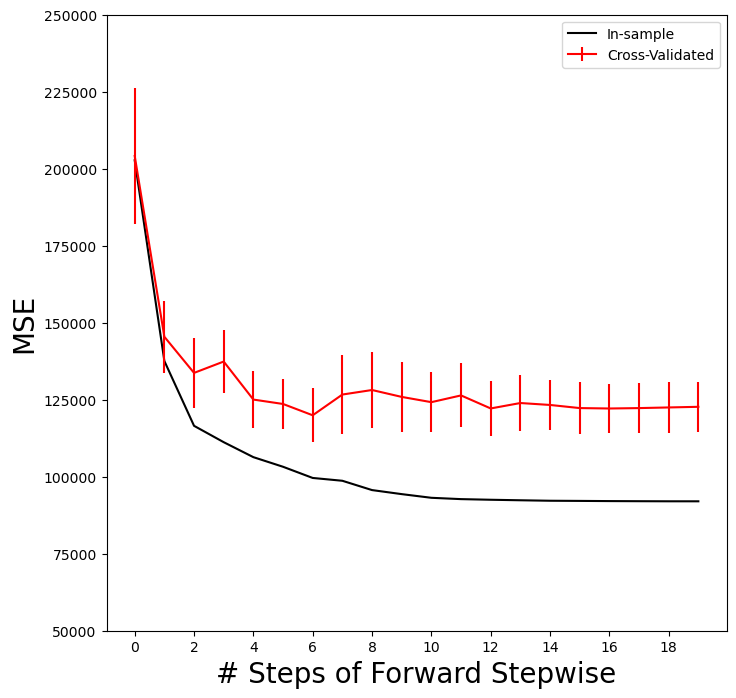

In [26]:
# Add cv error estimates to MSE plot
ax.errorbar(np.arange(n_steps), 
            cv_mse.mean(1),
            cv_mse.std(1) / np.sqrt(k),
            label='Cross-Validated', 
            c='r')
ax.set_ylim([50000, 250000])
ax.legend()
mse_fig

In [27]:
# Repeat using validation set approach
validation = skm.ShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
for train_idx, test_idx in validation.split(Y):
    full_path.fit(hitters.iloc[train_idx], Y[train_idx])
    Yhat_val = full_path.predict(hitters.iloc[test_idx])
    errors = (Yhat_val - Y[test_idx, None])**2
    validation_mse = errors.mean(0)

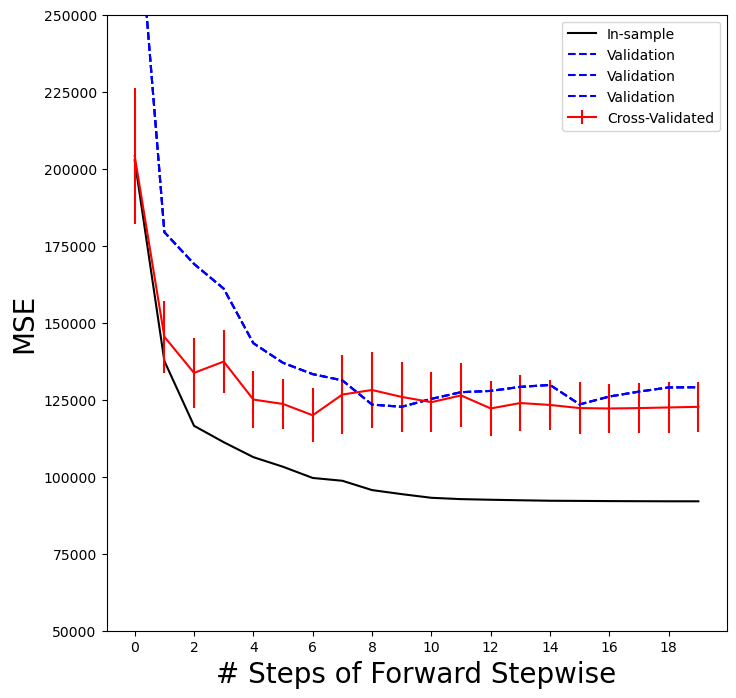

In [30]:
# Add validation errors to MSE plot
ax.plot(np.arange(n_steps), 
        validation_mse, 
        'b--', 
        label='Validation')
ax.set_xticks(np.arange(n_steps)[::2])
ax.set_ylim([50000,250000])
ax.legend()
mse_fig

#### Best Subset Selection:

The 10bnb package performs best subset selection by producing a path of solutions using the subset size as a penalty rather than a constraint. 

In [31]:
D = design.fit_transform(hitters)
D = D.drop('intercept', axis=1)
X = np.asarray(D)

In [32]:
path = fit_path(X, Y, max_nonzeros=X.shape[1])

Preprocessing Data.
BnB Started.
Iteration: 1. Number of non-zeros:  1
Iteration: 2. Number of non-zeros:  2
Iteration: 3. Number of non-zeros:  2
Iteration: 4. Number of non-zeros:  2
Iteration: 5. Number of non-zeros:  3
Iteration: 6. Number of non-zeros:  3
Iteration: 7. Number of non-zeros:  4
Iteration: 8. Number of non-zeros:  9
Iteration: 9. Number of non-zeros:  9
Iteration: 10. Number of non-zeros:  9
Iteration: 11. Number of non-zeros:  9
Iteration: 12. Number of non-zeros:  9
Iteration: 13. Number of non-zeros:  9
Iteration: 14. Number of non-zeros:  9
Iteration: 15. Number of non-zeros:  9
Iteration: 16. Number of non-zeros:  9
Iteration: 17. Number of non-zeros:  9
Iteration: 18. Number of non-zeros:  17
Iteration: 19. Number of non-zeros:  19


In [33]:
path[3]

{'B': array([0.        , 3.25484367, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.67775265, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ]),
 'B0': -38.98216739555551,
 'lambda_0': 0.011416248027450178,
 'M': 0.5829861733382012,
 'Time_exceeded': False}

In the fourth step in the path, we have two nonzero coefficients in 'B', corresponding to the value 0.114 for the penalty parameter lambda_0. 

### Ridge Regression and the Lasso

#### Ridge Regression

In [34]:
# Scale and standardize variables
Xs = X - X.mean(0)[None,:]
X_scale = X.std(0)
Xs = Xs / X_scale[None, :]

In [37]:
# Fit path along grid of lambda values
lambdas = 10**np.linspace(8, -2, 100) / Y.std()
soln_array = skl.ElasticNet.path(Xs, Y,
                                 l1_ratio=0, # ridge
                                 alphas=lambdas)[1]
soln_array.shape

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:617: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 64428165.36474803, tolerance: 12885.7065737425
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:617: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning:

(19, 100)

Associated with each value of lambda is a vector of ridge regression coefficients that can be accessed by a column of soln_array. In this case, soln_array is a 19 x 100 matrix with 19 rows (one for each predictor) and 100 columns (one for each value of lambda).

In [38]:
# Convert to dataframe
soln_path = pd.DataFrame(soln_array.T, columns=D.columns, index=-np.log(lambdas))
soln_path.index.name = 'negative log(lambda)'
soln_path

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League[N],Division[W],PutOuts,Assists,Errors,NewLeague[N]
negative log(lambda),,,,,,,,,,,,,,,,,,,
-12.310855,0.000800,0.000889,0.000695,0.000851,0.000911,0.000900,0.000812,0.001067,0.001113,0.001064,0.001141,0.001149,0.000993,-0.000029,-0.000390,0.000609,0.000052,-0.000011,-0.000006
-12.078271,0.001010,0.001122,0.000878,0.001074,0.001150,0.001135,0.001025,0.001346,0.001404,0.001343,0.001439,0.001450,0.001253,-0.000037,-0.000492,0.000769,0.000065,-0.000014,-0.000007
-11.845686,0.001274,0.001416,0.001107,0.001355,0.001451,0.001433,0.001293,0.001698,0.001772,0.001694,0.001816,0.001830,0.001581,-0.000046,-0.000621,0.000970,0.000082,-0.000017,-0.000009
-11.613102,0.001608,0.001787,0.001397,0.001710,0.001831,0.001808,0.001632,0.002143,0.002236,0.002138,0.002292,0.002309,0.001995,-0.000058,-0.000784,0.001224,0.000104,-0.000022,-0.000012
-11.380518,0.002029,0.002255,0.001763,0.002158,0.002310,0.002281,0.002059,0.002704,0.002821,0.002698,0.002892,0.002914,0.002517,-0.000073,-0.000990,0.001544,0.000131,-0.000028,-0.000015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.784658,-290.823989,336.929968,37.322686,-59.748520,-26.507086,134.855915,-17.216195,-387.775826,89.573601,-12.273926,476.079273,257.271255,-213.124780,31.258215,-58.457857,78.761266,53.622113,-22.208456,-12.402891
10.017243,-290.879272,337.113713,37.431373,-59.916820,-26.606957,134.900549,-17.108041,-388.458404,89.000707,-12.661459,477.031349,257.966790,-213.280891,31.256434,-58.448850,78.761240,53.645147,-22.198802,-12.391969
10.249827,-290.923382,337.260446,37.518064,-60.051166,-26.686604,134.936136,-17.022194,-388.997470,88.537380,-12.971603,477.791860,258.523025,-213.405740,31.254958,-58.441682,78.761230,53.663357,-22.191071,-12.383205


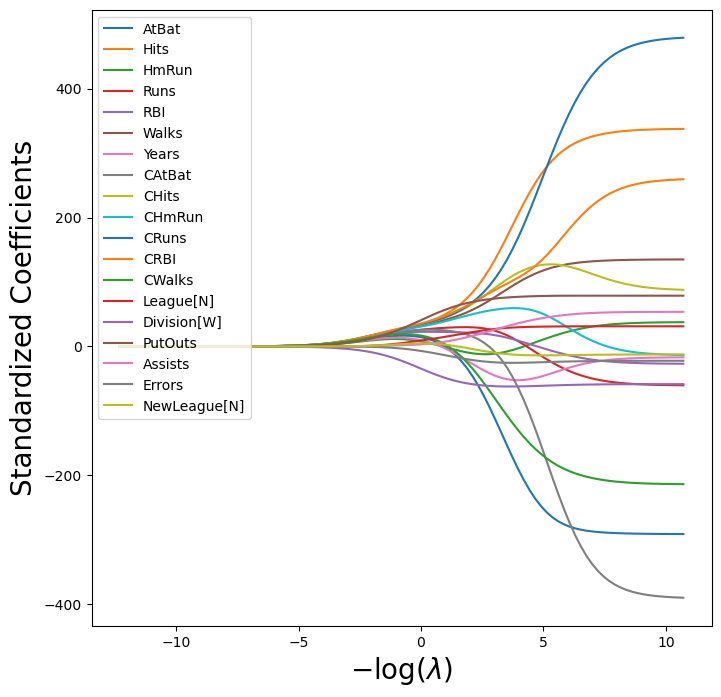

In [41]:
# Plot paths 
path_fig, ax = subplots(figsize=(8,8))
soln_path.plot(ax=ax, legend=False)
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized Coefficients', fontsize=20)
ax.legend(loc='upper left')

In [42]:
# Coefficients at 40th step
beta_hat = soln_path.loc[soln_path.index[39]]
lambdas[39], beta_hat

(25.53538897200662,
 AtBat           5.433750
 Hits            6.223582
 HmRun           4.585498
 Runs            5.880855
 RBI             6.195921
 Walks           6.277975
 Years           5.299767
 CAtBat          7.147501
 CHits           7.539495
 CHmRun          7.182344
 CRuns           7.728649
 CRBI            7.790702
 CWalks          6.592901
 League[N]       0.042445
 Division[W]    -3.107159
 PutOuts         4.605263
 Assists         0.378371
 Errors         -0.135196
 NewLeague[N]    0.150323
 Name: -3.240065292879872, dtype: float64)

In [43]:
# Compute L2 norm of standardized coefficients
np.linalg.norm(beta_hat)

24.17061720144378

In [44]:
# Separate feature normalization from model fitting
ridge = skl.ElasticNet(alpha=lambdas[59], l1_ratio=0)
scaler = StandardScaler(with_mean=True, with_std=True)
pipe = Pipeline(steps=[('scaler', scaler), ('ridge', ridge)])
pipe.fit(X,Y)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.446e+07, tolerance: 5.332e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', ElasticNet(alpha=0.24374766133488554, l1_ratio=0))])

In [46]:
np.linalg.norm(ridge.coef_)

160.4237101772591

**Estimating test error of ridge regression:**

In [47]:
# Validation method
validation = skm.ShuffleSplit(n_splits=1, test_size=0.5, random_state=0)
ridge.alpha = 0.01
results = skm.cross_validate(ridge, X, Y,
                             scoring='neg_mean_squared_error',
                             cv=validation)
-results['test_score']

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.486e+06, tolerance: 2.272e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


array([134214.00419204])

In [48]:
# Fit ridge regression model with very large lambda
ridge.alpha = 1e10
results = skm.cross_validate(ridge, X, Y,
                             scoring='neg_mean_squared_error',
                             cv=validation)
-results['test_score']

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.136e+07, tolerance: 2.272e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


array([231788.32155285])

In [49]:
# Use cross-validation to choose lambda
param_grid = {'ridge__alpha': lambdas}
grid = skm.GridSearchCV(pipe, param_grid, cv=validation,
                        scoring='neg_mean_squared_error')
grid.fit(X,Y)
grid.best_params_['ridge__alpha']
grid.best_estimator_

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.136e+07, tolerance: 2.272e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.136e+07, tolerance: 2.272e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.lin

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', ElasticNet(alpha=0.005899006046740856, l1_ratio=0))])

In [50]:
# Use 5-fold cross-validation
grid = skm.GridSearchCV(pipe, param_grid, cv=kfold, 
                        scoring='neg_mean_squared_error')
grid.fit(X,Y)
grid.best_params_['ridge__alpha']
grid.best_estimator_

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.880e+07, tolerance: 3.759e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.101e+07, tolerance: 4.201e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.lin

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', ElasticNet(alpha=0.01185247763144249, l1_ratio=0))])

Text(0, 0.5, 'Cross-validated MSE')

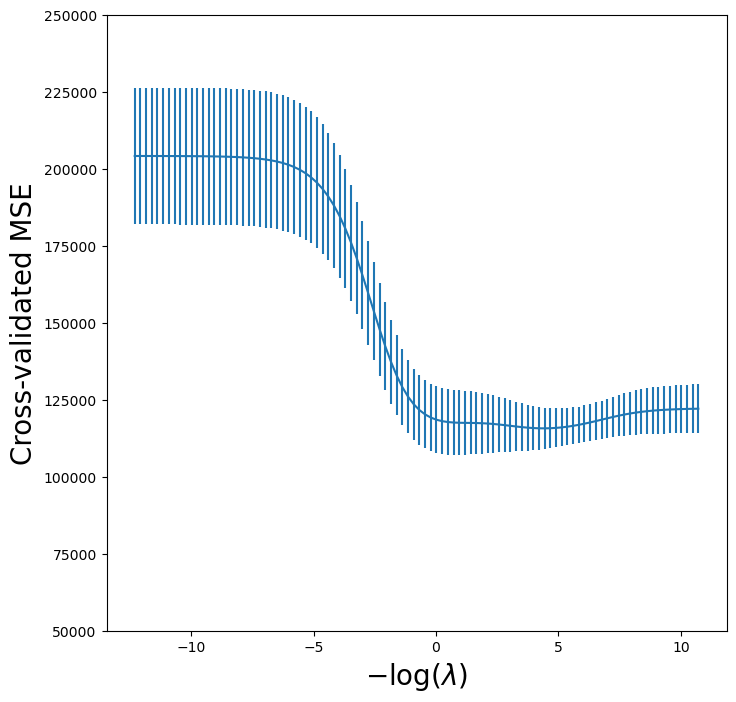

In [51]:
# Plot cross-validation MSE as a function of -log(lambda)
ridge_fig, ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(lambdas), 
            -grid.cv_results_['mean_test_score'],
            yerr=grid.cv_results_['std_test_score'] / np.sqrt(k))
ax.set_ylim([50000,250000])
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20)

In [52]:
# Compate R-squared to MSE for cross-validation
grid_r2 = skm.GridSearchCV(pipe, param_grid, cv=kfold)
grid_r2.fit(X,Y)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.880e+07, tolerance: 3.759e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.101e+07, tolerance: 4.201e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.lin

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('ridge',
                                        ElasticNet(alpha=10000000000.0,
                                                   l1_ratio=0))]),
             param_grid={'ridge__alpha': array([2.22093791e+05, 1.76005531e+05, 1.39481373e+05, 1.10536603e+05,
       8.75983676e+04, 6.94202082e+04, 5.50143278e+04, 4.35979140e+04,
       3.45506012e+04, 2.73807606...
       4.67486141e-03, 3.70474772e-03, 2.93594921e-03, 2.32668954e-03,
       1.84386167e-03, 1.46122884e-03, 1.15799887e-03, 9.17694298e-04,
       7.27257037e-04, 5.76338765e-04, 4.56738615e-04, 3.61957541e-04,
       2.86845161e-04, 2.27319885e-04, 1.80147121e-04, 1.42763513e-04,
       1.13137642e-04, 8.96596467e-05, 7.10537367e-05, 5.63088712e-05,
       4.46238174e-05, 3.53636122e-05, 2.80250579e-05, 2.22093791e-05])})

Text(0, 0.5, 'Cross-validated $R^2$')

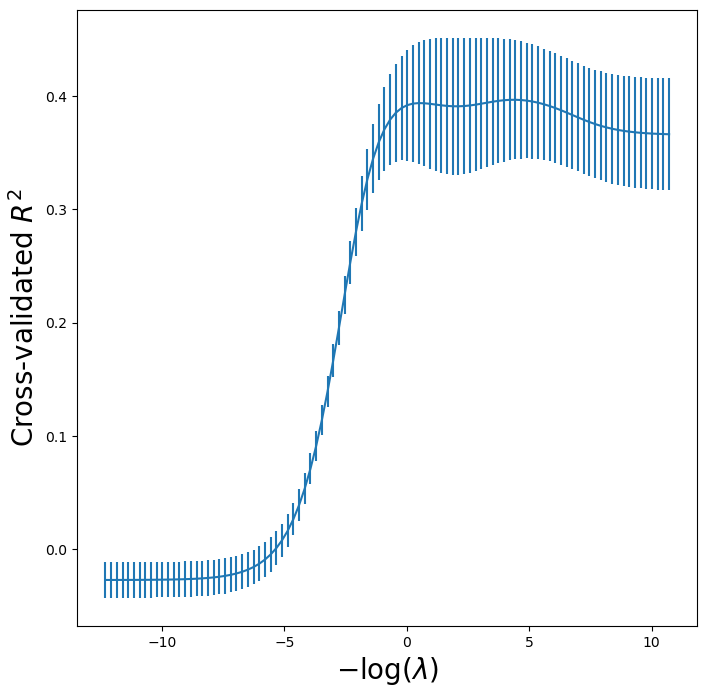

In [54]:
# Plot results fot R-squared
r2_fig, ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(lambdas), 
            grid_r2.cv_results_['mean_test_score'],
            yerr=grid_r2.cv_results_['std_test_score'] / np.sqrt(k))
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated $R^2$', fontsize=20)

**Evaluating test error of cross-validated ridge:**

In [55]:
outer_valid = skm.ShuffleSplit(n_splits=1, test_size=0.25, random_state=1)
inner_cv = skm.KFold(n_splits=5, shuffle=True, random_state=2)
ridgeCV = skl.ElasticNetCV(alphas=lambdas, l1_ratio=0, cv=inner_cv)
pipeCV = Pipeline(steps=[('scaler', scaler), ('ridge', ridgeCV)])

In [56]:
results = skm.cross_validate(pipeCV, X, Y, 
                             cv=outer_valid,
                             scoring='neg_mean_squared_error')
-results['test_score']

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:617: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16002961.893047336, tolerance: 3200.6325551004925
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:617: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarni

array([132393.84003227])

#### The Lasso

In [57]:
# Fit lasso model
lassoCV = skl.ElasticNetCV(n_alphas=100,
                           l1_ratio=1, # lasso
                           cv=kfold)
pipeCV = Pipeline(steps=[('scaler', scaler), ('lasso', lassoCV)])
pipeCV.fit(X,Y)
tuned_lasso = pipeCV.named_steps['lasso']
tuned_lasso.alpha_

3.1472370031649866

In [59]:
lambdas, soln_array = skl.Lasso.path(Xs, Y, l1_ratio=1, n_alphas=100)[:2]
solun_path = pd.DataFrame(soln_array.T, columns=D.columns, index=-np.log(lambdas))

Text(0, 0.5, 'Standardized coefficients')

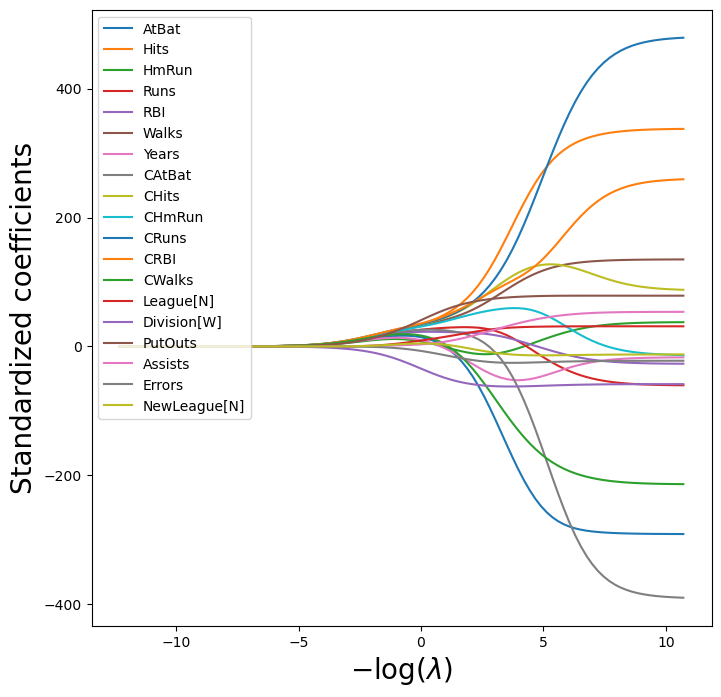

In [60]:
path_fig, ax = subplots(figsize=(8,8))
soln_path.plot(ax=ax, legend=False)
ax.legend(loc='upper left')
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Standardized coefficients', fontsize=20)

In [61]:
np.min(tuned_lasso.mse_path_.mean(1))

114690.73118253548

Text(0, 0.5, 'Cross-validated MSE')

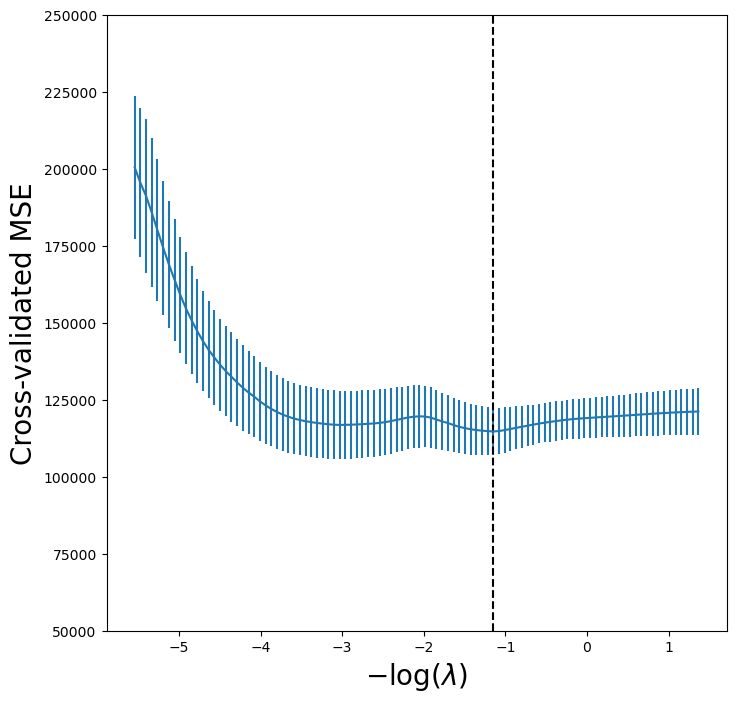

In [63]:
# Plot of cross-validation error
lassoCV_fig, ax = subplots(figsize=(8,8))
ax.errorbar(-np.log(tuned_lasso.alphas_),
            tuned_lasso.mse_path_.mean(1),
            yerr=tuned_lasso.mse_path_.std(1) / np.sqrt(k))
ax.axvline(-np.log(tuned_lasso.alpha_), c='k', ls='--')
ax.set_ylim([50000,250000])
ax.set_xlabel('$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Cross-validated MSE', fontsize=20)

In [64]:
tuned_lasso.coef_

array([-210.01008773,  243.4550306 ,    0.        ,    0.        ,
          0.        ,   97.69397357,  -41.52283116,   -0.        ,
          0.        ,   39.62298193,  205.75273856,  124.55456561,
       -126.29986768,   15.70262427,  -59.50157967,   75.24590036,
         21.62698014,  -12.04423675,   -0.        ])

### PCR and PLS Regression

### Principal Components Regression

In [65]:
# Perform PCR and fit linear regression model
pca = PCA(n_components=2)
linreg = skl.LinearRegression()
pipe = Pipeline([('pca', pca), ('linreg', linreg)])
pipe.fit(X,Y)
pipe.named_steps['linreg'].coef_

array([0.09846131, 0.4758765 ])

In [66]:
# Standardize data first
pipe = Pipeline([('scaler', scaler), ('pca', pca), ('linreg', linreg)])
pipe.fit(X,Y)
pipe.named_steps['linreg'].coef_

array([106.36859204, -21.60350456])

In [67]:
# Use cross-validation to select number of components
param_grid = {'pca__n_components': range(1,20)}
grid = skm.GridSearchCV(pipe, param_grid, cv=kfold,
                        scoring='neg_mean_squared_error')
grid.fit(X,Y)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA(n_components=2)),
                                       ('linreg', LinearRegression())]),
             param_grid={'pca__n_components': range(1, 20)},
             scoring='neg_mean_squared_error')

AttributeError: 'Axes' object has no attribute 'sest_xticks'

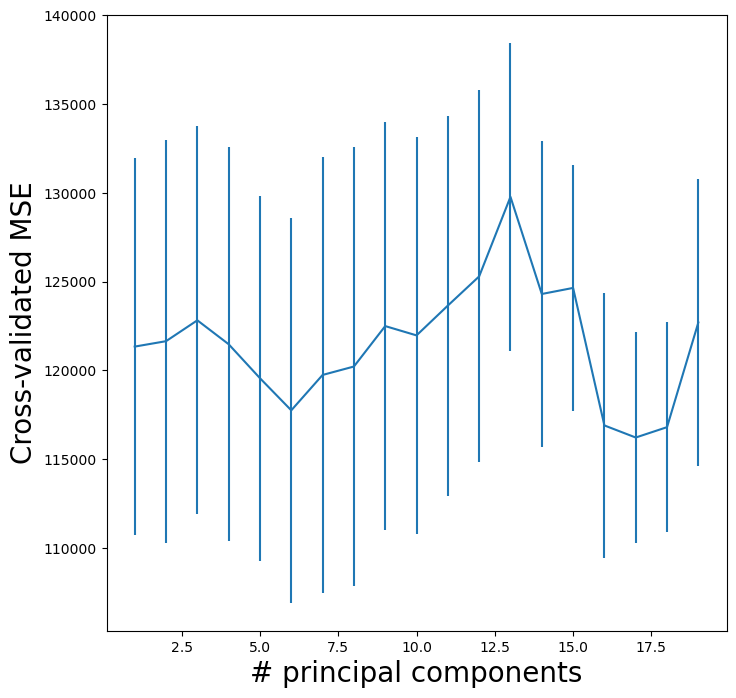

In [68]:
# Plot cross-validation results
pcr_fig, ax = subplots(figsize=(8,8))
n_comp = param_grid['pca__n_components']
ax.errorbar(n_comp, -grid.cv_results_['mean_test_score'],
            grid.cv_results_['std_test_score'] / np.sqrt(k))
ax.set_ylabel('Cross-validated MSE', fontsize=20)
ax.set_xlabel('# principal components', fontsize=20)
ax.sest_xticks(n_comp[::2])
ax.set_ylim([50000, 250000])

In [69]:
# Compute MSE for null model with these splits
Xn = np.zeros((X.shape[0], 1))
cv_null = skm.cross_validate(linreg, Xn, Y, cv=kfold,
                             scoring='neg_mean_squared_error')
-cv_null['test_score'].mean()

204139.30692994667

In [70]:
pipe.named_steps['pca'].explained_variance_ratio_

array([0.3831424 , 0.21841076])

#### Partial Least Squares:

In [71]:
pls = PLSRegression(n_components=2, scale=True)
pls.fit(X,Y)

PLSRegression()

In [72]:
# Use cross-validation to choose number of components
param_grid = {'n_components': range(1,20)}
grid = skm.GridSearchCV(pls, param_grid, cv=kfold, 
                        scoring='neg_mean_squared_error')
grid.fit(X,Y)

GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=PLSRegression(),
             param_grid={'n_components': range(1, 20)},
             scoring='neg_mean_squared_error')

(50000.0, 250000.0)

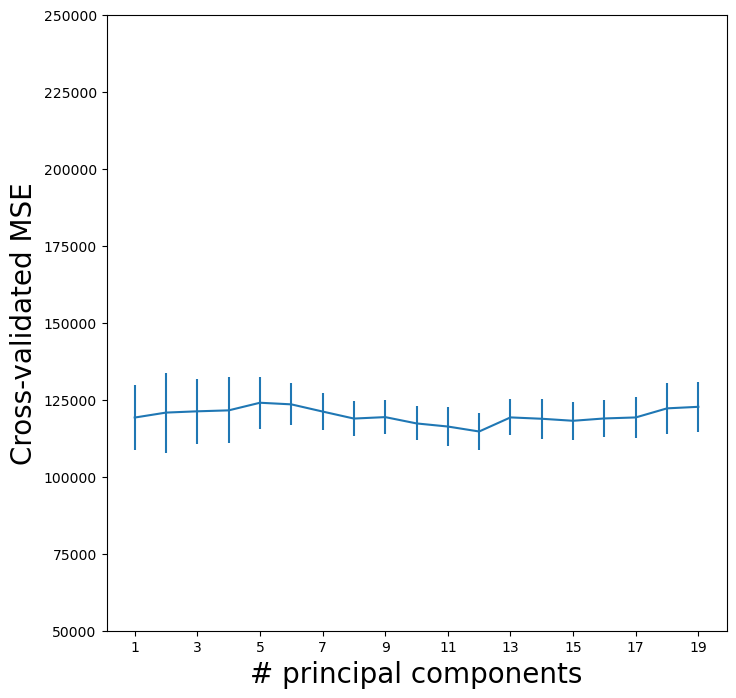

In [73]:
# Plot MSE 
pls_fig, ax = subplots(figsize=(8,8))
n_comp = param_grid['n_components']
ax.errorbar(n_comp,
            -grid.cv_results_['mean_test_score'],
            grid.cv_results_['std_test_score'] / np.sqrt(k))
ax.set_ylabel('Cross-validated MSE', fontsize=20)
ax.set_xlabel('# principal components', fontsize=20)
ax.set_xticks(n_comp[::2])
ax.set_ylim([50000,250000])